In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from glob import iglob
import matplotlib as mpl
from scipy.io import mmread
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import SpectralClustering
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 4
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
sns.set_palette('Set1')

In [3]:
sample_info = pd.read_csv('mSp_scATAC-seq/qc_all.csv', index_col=0)
sample_info.head(2)

frip  uniq_frags  mt_content  sequencing_depth  dup_level  \
cell                                                                           
mSp_rep10_001  0.726419     34703.0    0.008089            706791   0.946339   
mSp_rep10_002  0.670139     47380.0    0.021640           1055503   0.949220   

               frac_open  mapping_rate  plate          batch  
cell                                                          
mSp_rep10_001   0.177978         97.05  rep10  Sp#2 (n=2688)  
mSp_rep10_002   0.216714         96.44  rep10  Sp#2 (n=2688)

In [4]:
# load from mtx file

count = mmread('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.mtx')
idxs = [i.strip() for i in open('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.rownames')]
cols = [i.strip() for i in open('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.colnames')]

sc_count = pd.DataFrame(data=count.toarray(),
                        index=idxs,
                        columns=cols)

to_drop = pd.concat([pd.read_csv('mSp_scATAC-seq/qc_bad_cells.csv', index_col=0),
                     pd.read_csv('mSp_scATAC-seq/qc_possible_doublets.csv', index_col=0)])

sc_count.drop(labels=to_drop.index, axis=1, inplace=True)

# binarise the data
bin_sc_count = sc_count.where(sc_count < 1, 1)
bin_sc_count.shape

(127856, 3333)

In [5]:
np.percentile(bin_sc_count.sum(), 5)

5542.0

In [6]:
# filter cells and peaks

# at least 5542 peaks detected in the cell
bin_sc_count = bin_sc_count.loc[:,bin_sc_count.sum() > 5542]

# at least two cells have the peak
bin_sc_count = bin_sc_count.loc[bin_sc_count.sum(1) >= 2,]

sample_info = sample_info.loc[bin_sc_count.columns]
sc_count = sc_count.loc[bin_sc_count.index, bin_sc_count.columns]

bin_sc_count.shape

(126590, 3166)

In [7]:
# perform Latent Semantic Indexing Analysis

# get TF-IDF matrix
tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
normed_count = tfidf.fit_transform(bin_sc_count.T)

# perform SVD on the sparse matrix
lsi = TruncatedSVD(n_components=50, random_state=42)
lsi_r = lsi.fit_transform(normed_count)

lsi.explained_variance_ratio_

array([0.00359704, 0.03337308, 0.00874396, 0.0069396 , 0.00389355,
       0.00241397, 0.00221444, 0.0019063 , 0.00149011, 0.00132052,
       0.00115474, 0.00109362, 0.00091509, 0.00083675, 0.00080732,
       0.00077542, 0.00070272, 0.00068356, 0.00065285, 0.00062508,
       0.00057935, 0.00055276, 0.00052353, 0.00050493, 0.00050313,
       0.00048385, 0.0004767 , 0.00045395, 0.00044116, 0.00043018,
       0.00042416, 0.00042186, 0.00041577, 0.00040895, 0.00040376,
       0.00039975, 0.0003949 , 0.00039141, 0.00039021, 0.00038806,
       0.00038729, 0.0003851 , 0.00038324, 0.00038308, 0.00038246,
       0.00038155, 0.00037991, 0.00037821, 0.00037688, 0.0003762 ])

In [8]:
# since we know that the first LSI dimension is related to sequencing depth
# we just ignore the first dimension since, and only pass the 2nd dimension and onwards for t-SNE
X_lsi = lsi_r[:, 1:]
tsne = TSNE(n_components=2,
            learning_rate=200,
            random_state=42,
            n_jobs=10).fit_transform(X_lsi)

sample_info['t-SNE Dimension 1'] = tsne[:, 0]
sample_info['t-SNE Dimension 2'] = tsne[:, 1]

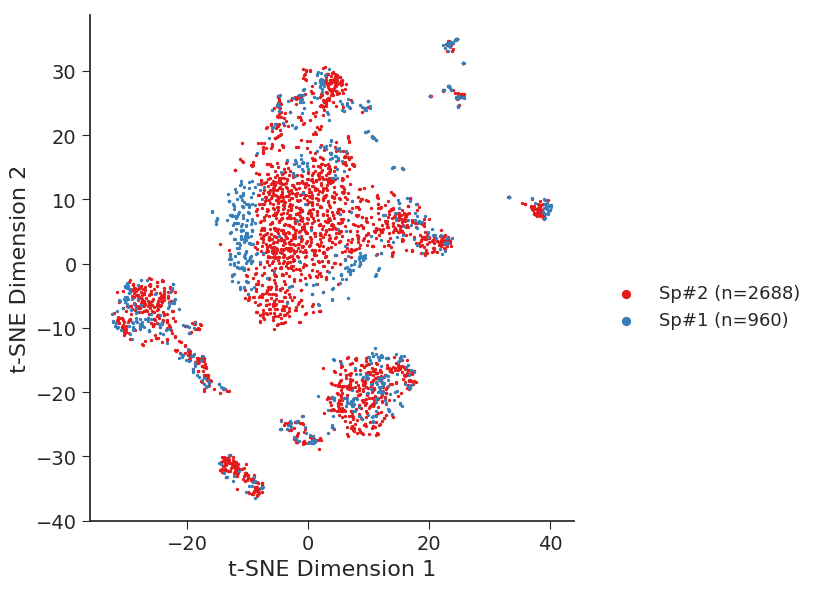

In [9]:
g = sns.FacetGrid(sample_info, hue='batch', size=6, palette='Set1')
g.map(plt.scatter, 't-SNE Dimension 1', 't-SNE Dimension 2', s=2)

g.ax.legend(bbox_to_anchor=[1.5, .5])
plt.savefig('figures/tSNE_colored_by_batch.pdf',
            bbox_inches='tight', transparent=True)

In [10]:
# similar to the sci-ATAC-seq from the Drosophila embryos:
# Cusanovich et al. Nature 555, 538–542
# http://atlas.gs.washington.edu/fly-atac/docs

# we ignore the first LSI dimension by setting it to zero
# then we invert it back to its original space

lsi_r[:, 0] = 0
matrix = lsi.inverse_transform(lsi_r)
matrix.shape

(3166, 126590)

In [11]:
# perform spectral clustering on cells using the new matrix

cluster = SpectralClustering(n_clusters=12,
                             n_jobs=-1,
                             affinity='nearest_neighbors',
                             random_state=42, n_neighbors=15,
                             assign_labels='discretize',
                             n_init=50).fit(scale(matrix))

In [12]:
sample_info['cluster_labels'] = cluster.labels_
sample_info.cluster_labels.value_counts()
# output {0: 85, 1: 1358, 2: 116, 3: 454, 4: 254, 5: 55,
#         6: 331, 7: 223, 8: 75, 9: 89, 10: 61, 11: 65}

1     1358
3      454
6      331
4      254
7      223
2      116
9       89
0       85
8       75
11      65
10      61
5       55
Name: cluster_labels, dtype: int64

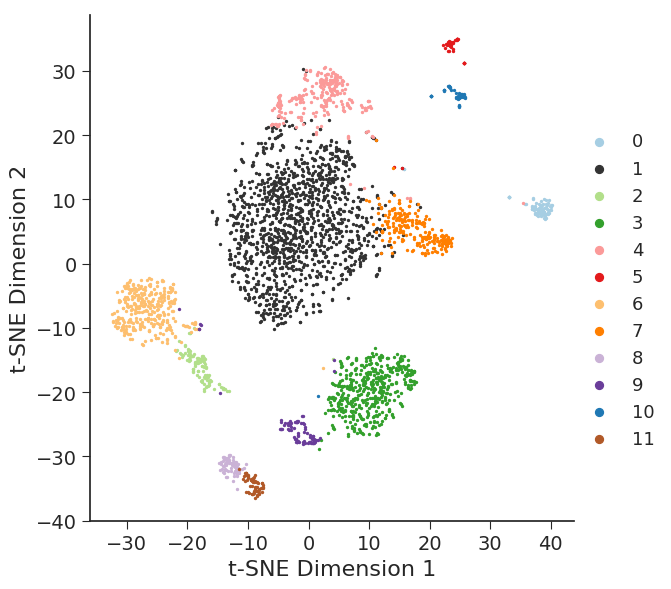

In [13]:
color12 = ['#a6cee3', '#333333', '#b2df8a', '#33a02c',
           '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
           '#cab2d6', '#6a3d9a', '#1f78b4', '#b15928']

g = sns.FacetGrid(sample_info, hue='cluster_labels', size=6, palette=sns.color_palette(color12))
g.map(plt.scatter, 't-SNE Dimension 1', 't-SNE Dimension 2', s=2)
g.ax.legend(bbox_to_anchor=[1.2,0.8])
plt.savefig('figures/tSNE_colored_by_clustering.pdf', bbox_inches='tight', transparent=True)

# Use LogisticRegression to pull out important peaks that define clusters

In [14]:
# # test a logistic regression model

from sklearn.model_selection import cross_val_score, StratifiedKFold

X = bin_sc_count.T
y = cluster.labels_

cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

logit = LogisticRegression(penalty='l2',
                           random_state=42,
                           solver='liblinear')
scores = cross_val_score(logit, X, y, cv=cv)
scores

array([0.93720565, 0.95268139, 0.94006309, 0.93829114, 0.94594595])

In [15]:
logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
logit.score(X, y)

1.0

In [17]:
logit.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [18]:
logit.coef_.shape

(12, 126590)

In [19]:
# get cell-type (cluster) defining peaks

marker_peaks = pd.DataFrame({
               'class_': logit.classes_[logit.coef_.argmax(0)],
               'peak': X.columns,
               'weight': logit.coef_.max(0)
               })

marker_peaks.query('weight > 0').shape

(126433, 3)

In [20]:
# get top 500 peaks from each cell type prediction

top_peaks = (
            marker_peaks.query('weight > 0.')
                        .sort_values('weight', ascending=False)
                        .groupby('class_')
                        .head(500)
                        .sort_values(['class_', 'weight'], ascending=[True, False])
            )

top_peaks.head(2)

class_               peak    weight
101965       0  spleen_uPk_102966  0.017903
30679        0   spleen_uPk_30938  0.016020

In [21]:
# read HOMER annotation to get the nearest gene associated with each peak

homer = pd.read_table('cmp_to_immgen/homer_annotation_spleen_union_peaks_no_black_list.txt',
                      index_col=0)

In [22]:
top_peaks.set_index('peak', inplace=True)
top_peaks = pd.concat([top_peaks,
                       homer.loc[top_peaks.index,
                                 ['Chr', 'Start', 'End',
                                  'Annotation', 'Distance to TSS',
                                  'Gene Name']
                                ]
                       ], axis=1)
top_peaks.sort_values(['class_', 'weight'], ascending=[True, False], inplace=True)

In [23]:
# have a look genes associated with the top 50 peaks in each cluster

top_genes = pd.DataFrame(
                         data = (top_peaks.groupby('class_')
                                          .head(50)['Gene Name']
                                          .values.reshape(12, 50)
                                          .T
                                ),
                         columns = ['cluster{}'.format(i) for i in range(12)])
top_genes

cluster0       cluster1   cluster2       cluster3       cluster4  \
0             Cd9         Fcer2a     Ptpn12          Myo10          Cdh26   
1            Lyst          Chil4     Katnb1         Pdlim4           Dtx1   
2           Cxcr4         B3gnt7      Ypel1          Trub1          Ackr3   
3          Cd300a        Mir7211      S100z          Klhl5            Cd9   
4           Cxcr2         Zfp407       Pigv          Itsn2       AW011738   
5          Taldo1          Bmp2k    Mir7683         Polr1a          Taok3   
6          Map2k3          Xylt1     Gm6981  1700042G15Rik          Smyd2   
7           Cxcl5           Wwox      Il2rb          Siah3     Mirlet7a-1   
8            Nfe2          Stpg2      Mylip        Gm11186          Cdh26   
9         Tacstd2  1110059E24Rik    Gm13547  1700056E22Rik          Ackr3   
10         Fam63a        Tmem252      Runx2            Cd4       Serpine2   
11          Cxcr2         Rps15a    Tmevpg1           Gcm2          Thada   
12          Rplp0       Tmprss13   Cdc42ep1        Gm13986        Dennd2d   
13          Tgif2         Zfp318     Ppp4r2          Epas1           Rgmb   
14         Taldo1       AI427809     Gpr183          Itgb3           Dtx1   
15           Pygl  1700016K19Rik     Igsf23        Gm15417      LOC215458   
16           E2f2          Ciita     Dnaja2           Gcc1         Echdc3   
17        Mir7021          Sorl1       Rgs3          Cdhr3           Mzb1   
18         Slc2a3         Shank1      Sycp3       Olfr1510       Cdc42bpb   
19           Ptma         Sacm1l    Gm38403        Gm13582            Gns   
20        Tacstd2          H2-Aa      Abhd2        St8sia6           Myof   
21         Fbxo31          Icosl   Cdk5rap3           Adar          Gpr55   
22          Cxcr2        Osbpl10    Tmevpg1         Pdlim4            NaN   
23         Ifitm5         Sergef      Samd3         Mir151  4930581F22Rik   
24          Ckap4         Nup133     Smndc1          Sugct         Ptpn14   
25         Zbtb16          Stap1      Abhd2         Zfp800          Cxcr4   
26          Tigd4          Pakap      Galr1        Cd200r3           Ubl3   
27  C130050O18Rik          H2-Aa       Drc1         Calcrl        Zfp36l1   
28          Csf3r     Gpr137b-ps      Gabrp        Fam105a         Coro2b   
29         Rabac1       H2-Ea-ps    Dynlrb2          Dapk1         Setbp1   
30         Nlrp12          Ppdpf      Kdm4d  4933406K04Rik            Blk   
31            Emb          Cenpe        Txk         Tgfbr3        Mir1941   
32           Myh9          Icosl     Agtr1b        Slc19a3           Dtx1   
33            Pgd          Enpp6       Cmc1          Myo10          Akap5   
34           Zeb2          Pxdc1    Mir7057        B4galt5          Sirpa   
35          Gcnt2          Capzb      Fosl2           Pno1          Prkcz   
36          Itgb2         H2-Eb1      Parp8          Epas1        Gm15713   
37          Susd1         Stoml1  Serpina12           Msra           Cmah   
38          Grina           Rgs9    Olfr525          Unc80          Kmt2a   
39         Mrpl33           Scd1     Gimap4           Ibtk          Hmgn3   
40          Dmxl2         Ptpn11        Fyn           Chl1          Atxn1   
41          Reep3         B3gat2     Btbd11           Chdh         Tsga13   
42          Cxcr1            Ezr      Runx2           Mtx2          Plac8   
43        Slc11a1       Rasgef1b       Ccl5          Tnni1          Atxn1   
44          Slmap  9030404E10Rik    Gm38403            Cck            Syk   
45          Csf3r          Helz2      Nosip        Zscan10           Cbx4   
46         Arntl2         Chrna9      Runx2         Fam65b           Fasl   
47          Ndel1          Parp8      Kcnj8          Cers6          Rps24   
48          Ptafr         March1     Mapre2          Kif23        Slc31a2   
49           Map7         Akap13    Fam169b      Rab11fip4         Dusp16   

         cluster5       cluster6       cluster7       cluster8       cluster9  \


# Compare with ImmGen bulk ATAC-seq and check marker genes to annotate clusters

In [24]:
immgen_anno = pd.read_table('immgen_atac/PRJNA392905.txt', index_col='run_accession')
immgen_anno = immgen_anno[immgen_anno.sample_title.str.contains('Sp#')]
immgen_anno['sample_name'] = immgen_anno.sample_title.str.replace('Sp#', '')
rename = dict(immgen_anno.sample_name)
immgen_anno.head(2)

study_accession sample_accession secondary_sample_accession  \
run_accession                                                               
SRR5799398        PRJNA392905     SAMN07312033                 SRS2332759   
SRR5799399        PRJNA392905     SAMN07312032                 SRS2332758   

              experiment_accession  tax_id scientific_name instrument_model  \
run_accession                                                                 
SRR5799398              SRX2978865   10090    Mus musculus      NextSeq 500   
SRR5799399              SRX2978866   10090    Mus musculus      NextSeq 500   

              library_layout  sample_title sample_name  
run_accession                                           
SRR5799398            PAIRED  T.4.Nve.Sp#1   T.4.Nve.1  
SRR5799399            PAIRED  T.4.Nve.Sp#2   T.4.Nve.2

In [25]:
immgen_count = pd.read_csv('cmp_to_immgen/immgen_count_matrix_over_all.csv',
                           index_col=0)
immgen_count.rename(columns=rename, inplace=True)

In [26]:
g = sample_info.groupby('cluster_labels')

dfs = [immgen_count]

# aggregate cells within the same cluster
for i in range(12):
    sub_cells = g.get_group(i).index
    dfs.append(pd.DataFrame(data = sc_count.loc[top_peaks.index, sub_cells].sum(1),
                            columns=['cluster_{}'.format(i)]))

# get the count matrix of ImmGen bulk and single cell on the top 6,000 peaks.
merged_cm = pd.concat(dfs, axis=1, join='inner')

In [27]:
merged_cm.shape

(6000, 75)

In [28]:
# get reads per million for each peak in each sample
normed_cm = merged_cm / merged_cm.sum() * 1e6
normed_cm.head(2)

B.mem.1  T8.Tcm.LCMV.d180.1  T.8.Nve.1   B.GC.CB.1  \
spleen_uPk_121  396.833404          548.308496  750.41876  227.630115   
spleen_uPk_147   60.533909          100.709724   26.80067   16.259294   

                  DC.8+.2      B.MZ.1      B.PC.2    B.mem.2  \
spleen_uPk_121  96.458370  320.369958  559.763624  409.68777   
spleen_uPk_147   4.019099   48.751950   14.171231    0.00000   

                T8.Tem.LCMV.d180.2         B.2     ...       cluster_2  \
spleen_uPk_121          251.915687  301.780972     ...      598.907717   
spleen_uPk_147          109.038133    9.285568     ...       95.736178   

                  cluster_3   cluster_4   cluster_5   cluster_6   cluster_7  \
spleen_uPk_121  1003.720320  544.360024  116.102978  875.215165  535.001440   
spleen_uPk_147    11.845637   10.635809    0.000000   13.147009    7.965282   

                 cluster_8   cluster_9  cluster_10  cluster_11  
spleen_uPk_121  179.671243  606.531307  248.640764  342.285413  
spleen_uPk_147  359.342487   33.285255   22.101401  294.014394  

[2 rows x 75 columns]

In [29]:
scaled = pd.DataFrame(scale(normed_cm, 1),
                      index=normed_cm.index,
                      columns=normed_cm.columns)

In [30]:
corr = scaled.corr()

In [31]:
corr.shape

(75, 75)

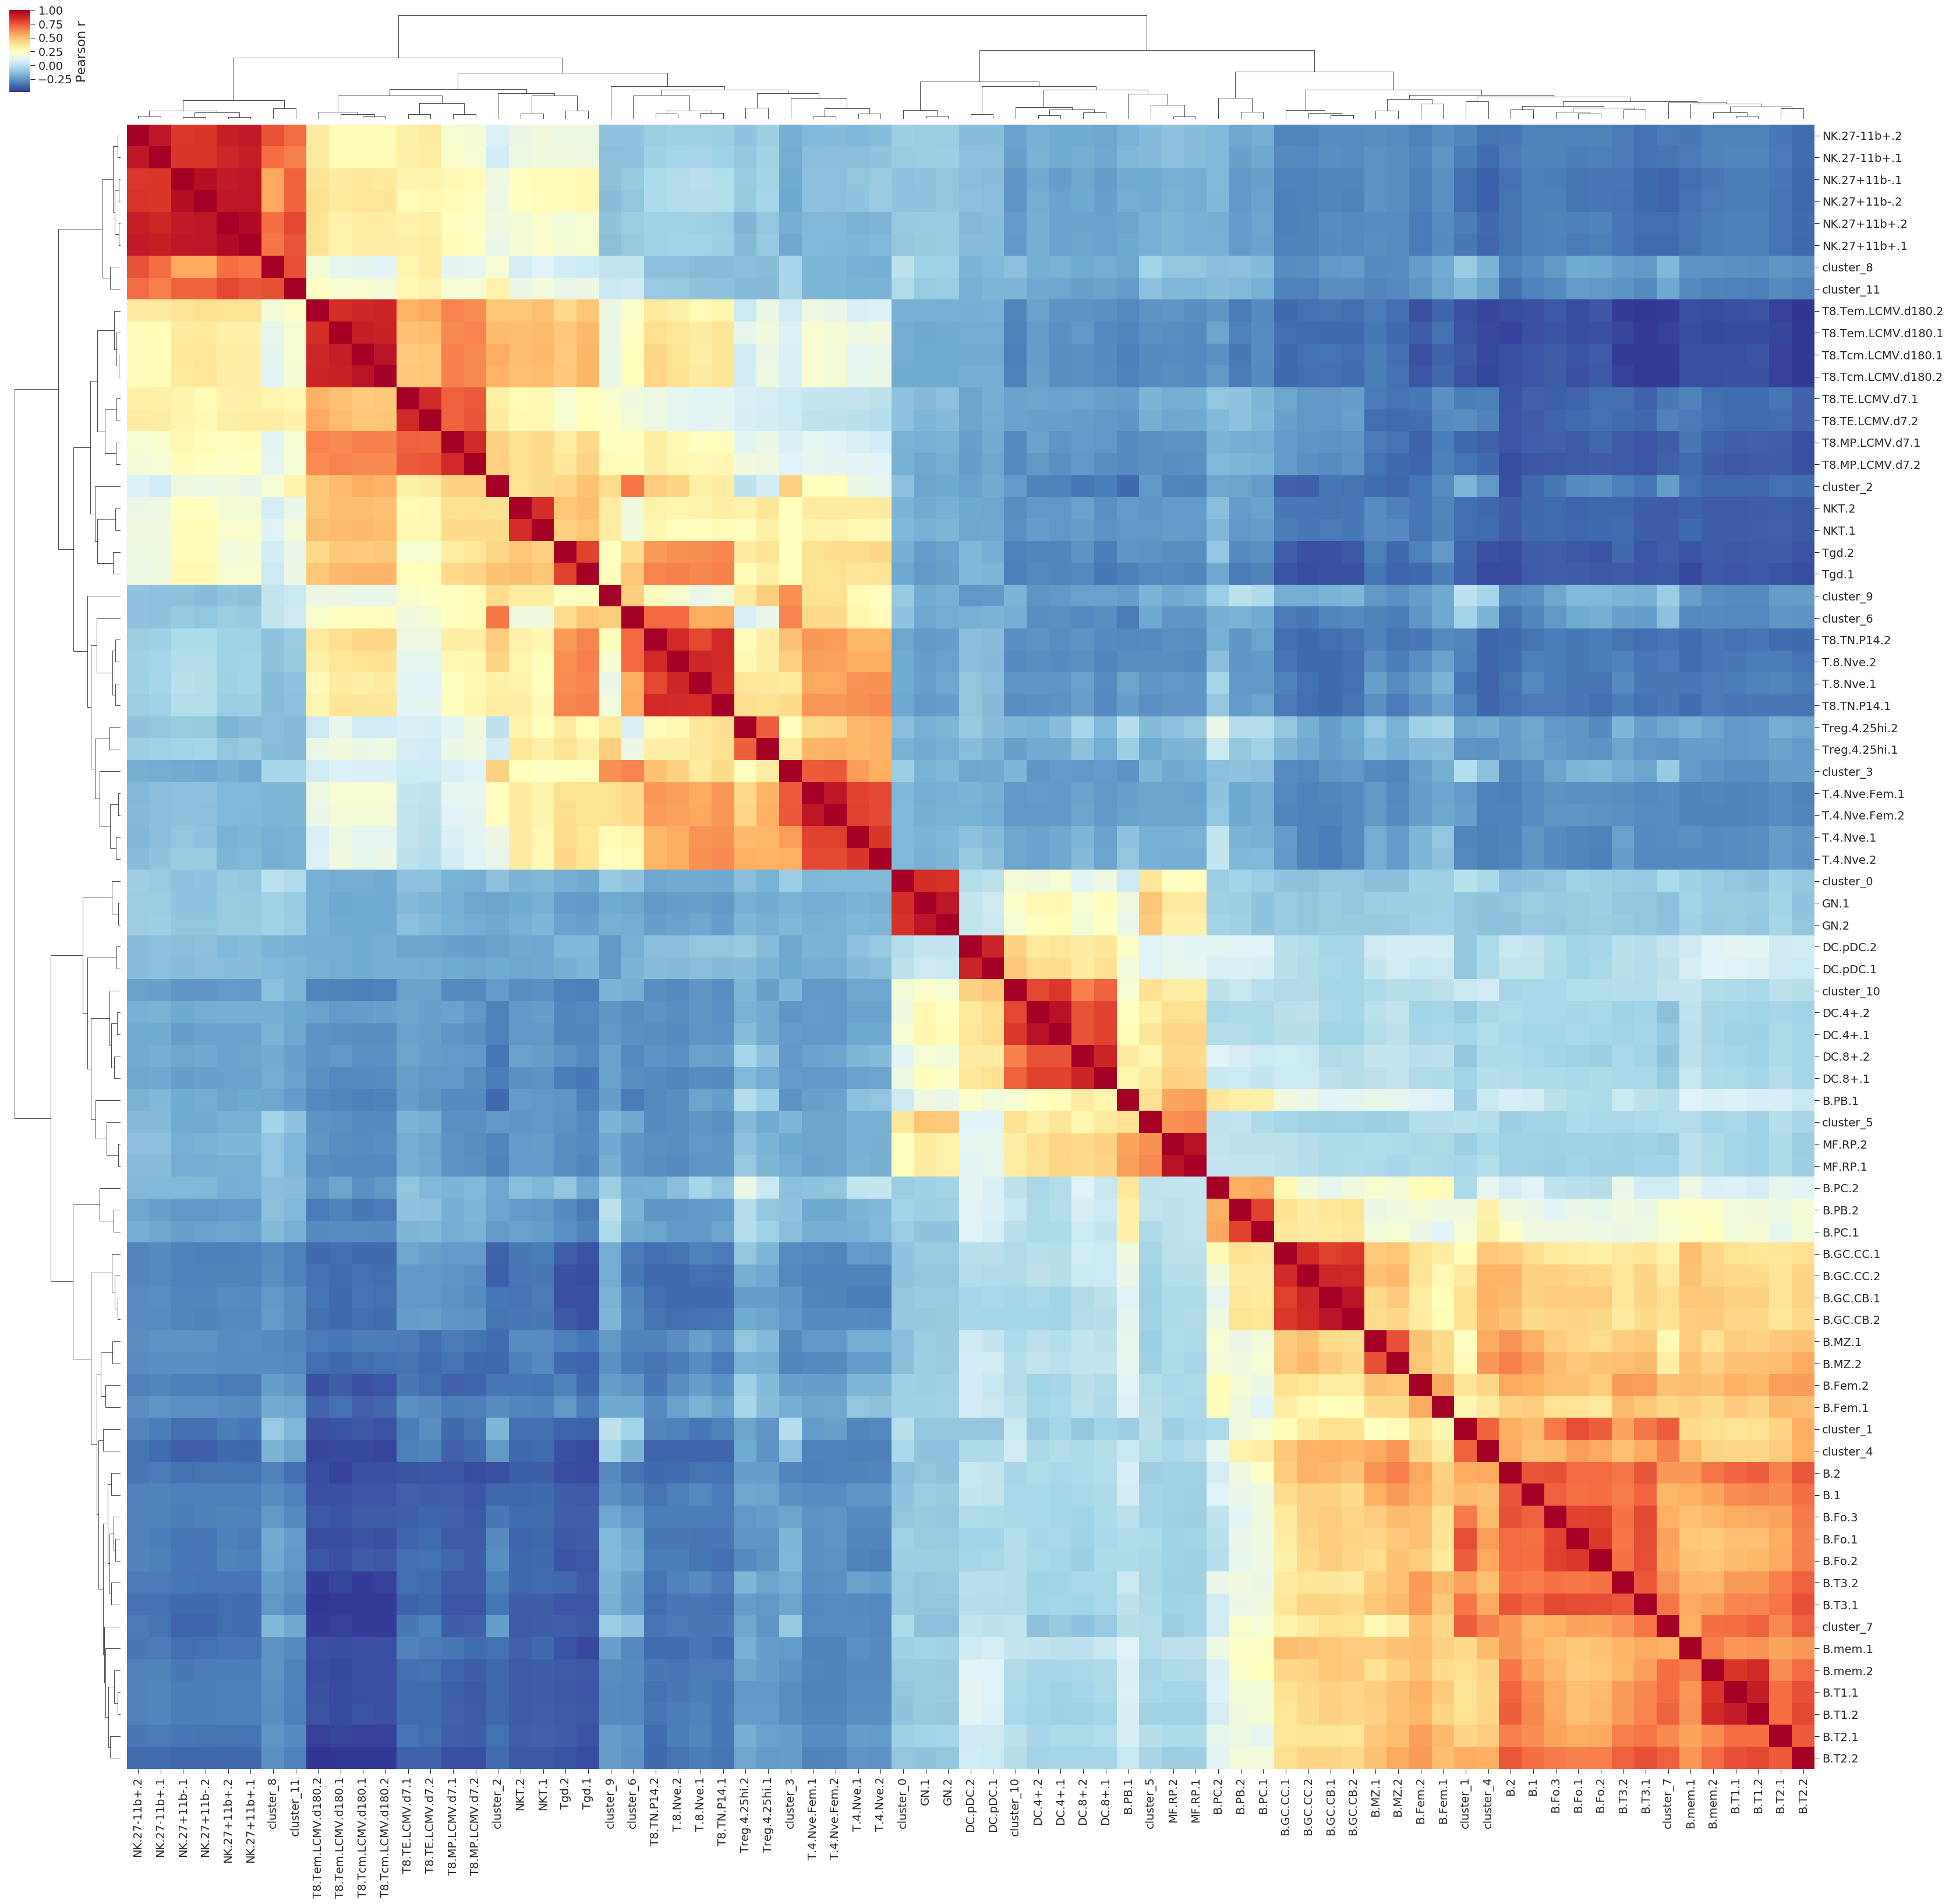

In [32]:
# to make sure there is no white line in-between cells when saving as pdf,
# pass rasterized=True in sns.clustmap
# https://github.com/mwaskom/seaborn/issues/373

hcl = sns.clustermap(corr, cmap="RdYlBu_r",
                     figsize=(40,40),
                     linewidths=0,
                     linecolor=None,
                     cbar_kws={'label' : 'Pearson r'},
                     rasterized=True)
hcl.savefig('figures/scATAC_cluster_aggregate_immgen_hcl_full_matrix.pdf',
            bbox_inches='tight', transparent=True)

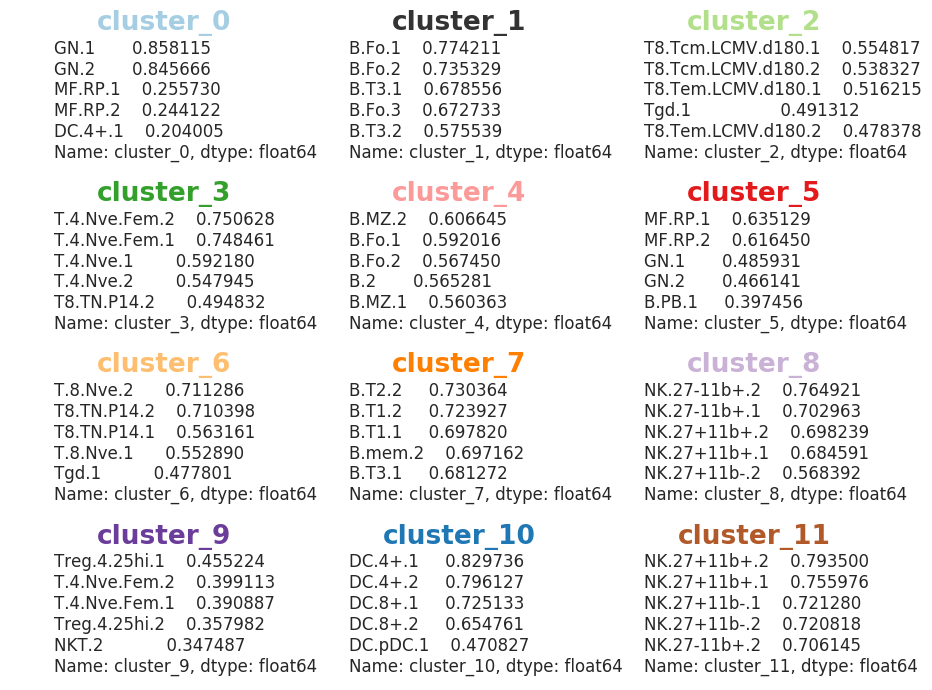

In [33]:
# print the correlation values (pearson r)

corr.drop(labels=['cluster_{}'.format(i) for i in range(12)],
          inplace=True) # remove single cell clusters correlation with one another

fig, ax = plt.subplots(figsize=(9, 7), nrows=4, ncols=3)
ax = ax.flatten()

for i,j in enumerate(logit.classes_):
    print_corr = str(corr['cluster_{}'.format(j)].sort_values(ascending=False).head(5))
    ax[i].set_title('cluster_{}'.format(j), weight='bold', color=color12[i])
    ax[i].text(0, -0.25, print_corr, fontsize=12)
    ax[i].set_axis_off()

fig.tight_layout()
fig.savefig('figures/top_correlated_sample_with_each_cluster.pdf',
            bbox_inches='tight', transparent=True)

In [34]:
hm_sample_id = ['B.Fo.1', 'B.Fo.2',
                'B.MZ.1', 'B.MZ.2',
                'B.T2.1', 'B.T2.2',
                'DC.4+.1', 'DC.4+.2',
                'GN.1', 'GN.2',
                'MF.RP.1', 'MF.RP.2',
                'NK.27+11b+.1', 'NK.27+11b+.2',
                'NK.27-11b+.1', 'NK.27-11b+.2',
                'Treg.4.25hi.1', 'Treg.4.25hi.2',
                'T.4.Nve.Fem.1', 'T.4.Nve.Fem.2',
                'T.8.Nve.1', 'T.8.Nve.2',
                'T8.Tcm.LCMV.d180.1', 'T8.Tcm.LCMV.d180.2']
hm_sample_id.extend(['cluster_{}'.format(i) for i in range(12)])

sub_normed_cm = normed_cm.loc[:, hm_sample_id]

In [35]:
sub_scaled = pd.DataFrame(scale(sub_normed_cm, 1),
                          index=sub_normed_cm.index,
                          columns=sub_normed_cm.columns)

In [36]:
sub_corr = sub_scaled.corr()

In [37]:
sub_corr.shape

(36, 36)

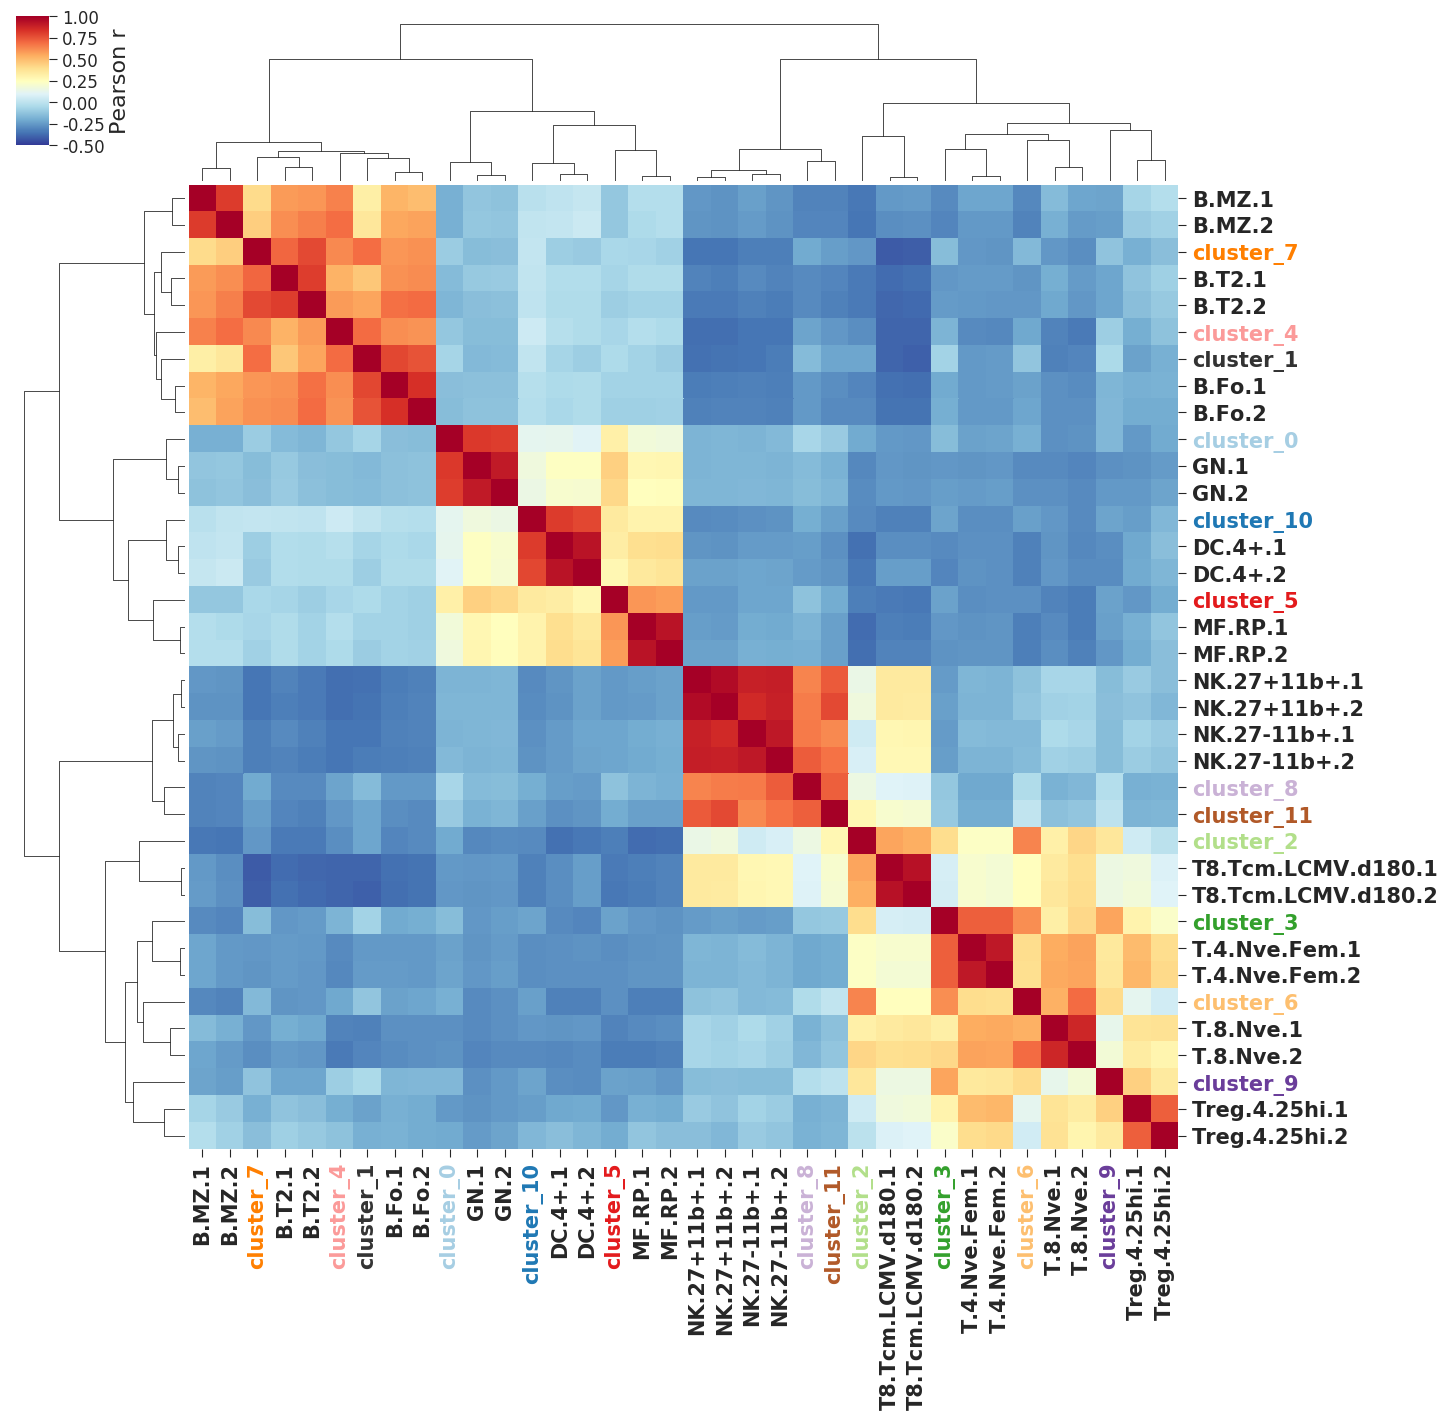

In [38]:
hcl = sns.clustermap(sub_corr,
                     cmap="RdYlBu_r",
                     vmin=-0.5, vmax=1.,
                     linewidths=0,
                     linecolor=None,
                     cbar_kws={'label' : 'Pearson r'},
                     rasterized=True,
                     figsize=(15,15))

hcl.cax.set_yticklabels(['-0.50', '-0.25', '0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=12)

xts = hcl.ax_heatmap.get_xticklabels()
yts = hcl.ax_heatmap.get_yticklabels()

for tks in [xts, yts]:
    for tk in tks:
        t = tk.get_text()
        tk.set_fontsize(15)
        tk.set_weight('bold')
        if 'cluster' in t:
            i = int(t.split('_')[1])
            tk.set_color(color12[i])

hcl.savefig('figures/scATAC_cluster_aggregate_immgen_hcl_sub_matrix.pdf',
             bbox_inches='tight', transparent=True)

# Check the counts in peaks around some marker genes

In [39]:
marker_genes = ['Bcl11a', 'Cd19', 'Ms4a1', 'Ebf1',
                'Fcer2a', 'Ptprc', 'Cxcr5',
                'Cd9', 'Cr2', 'Cd1d1', 'Tcf3', 'Pou2f2',
                'Cd3e', 'Cd4', 'Cd8a', 'Bcl11b', 'Tcf7',
                'Gzma', 'Adamts14', # NK cells
                'Lrg1', 'Csf3r', # granulocyte
                'Lyz1', 'Itgax', 'Mafb', # monocyte etc
                'Cd44']

In [40]:
p2g_count = pd.concat([sc_count, homer['Gene Name']], axis=1, join='inner')
p2g_count.head(2)

mSp_rep7_276  mSp_rep7_267  mSp_rep7_270  mSp_rep7_291  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              mSp_rep7_196  mSp_rep7_347  mSp_rep7_141  mSp_rep7_079  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              mSp_rep7_199  mSp_rep7_082    ...      mSp_rep6_216  \
spleen_uPk_1             0             0    ...                 0   
spleen_uPk_2             0             0    ...                 0   

              mSp_rep6_110  mSp_rep6_353  mSp_rep6_174  mSp_rep6_255  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              mSp_rep6_250  mSp_rep6_280  mSp_rep6_302  mSp_rep6_019  \
spleen_uPk_1             0             0             0             0   
spleen_uPk_2             0             0             0             0   

              Gene Name  
spleen_uPk_1       Xkr4  
spleen_uPk_2       Xkr4  

[2 rows x 3167 columns]

In [41]:
gene_reg_sum = p2g_count.groupby('Gene Name').sum()
gene_reg_sum.head(2)

mSp_rep7_276  mSp_rep7_267  mSp_rep7_270  mSp_rep7_291  \
Gene Name                                                               
0610005C13Rik             0             0             2             6   
0610007P14Rik             0             0             0             0   

               mSp_rep7_196  mSp_rep7_347  mSp_rep7_141  mSp_rep7_079  \
Gene Name                                                               
0610005C13Rik             0             2             4             2   
0610007P14Rik             0             0             0             0   

               mSp_rep7_199  mSp_rep7_082      ...       mSp_rep6_282  \
Gene Name                                      ...                      
0610005C13Rik             2             0      ...                  1   
0610007P14Rik             0             0      ...                  0   

               mSp_rep6_216  mSp_rep6_110  mSp_rep6_353  mSp_rep6_174  \
Gene Name                                                               
0610005C13Rik             2             2             0             2   
0610007P14Rik             0             0             0             0   

               mSp_rep6_255  mSp_rep6_250  mSp_rep6_280  mSp_rep6_302  \
Gene Name                                                               
0610005C13Rik             0             2             0             0   
0610007P14Rik             0             4             0             0   

               mSp_rep6_019  
Gene Name                    
0610005C13Rik             0  
0610007P14Rik             0  

[2 rows x 3166 columns]

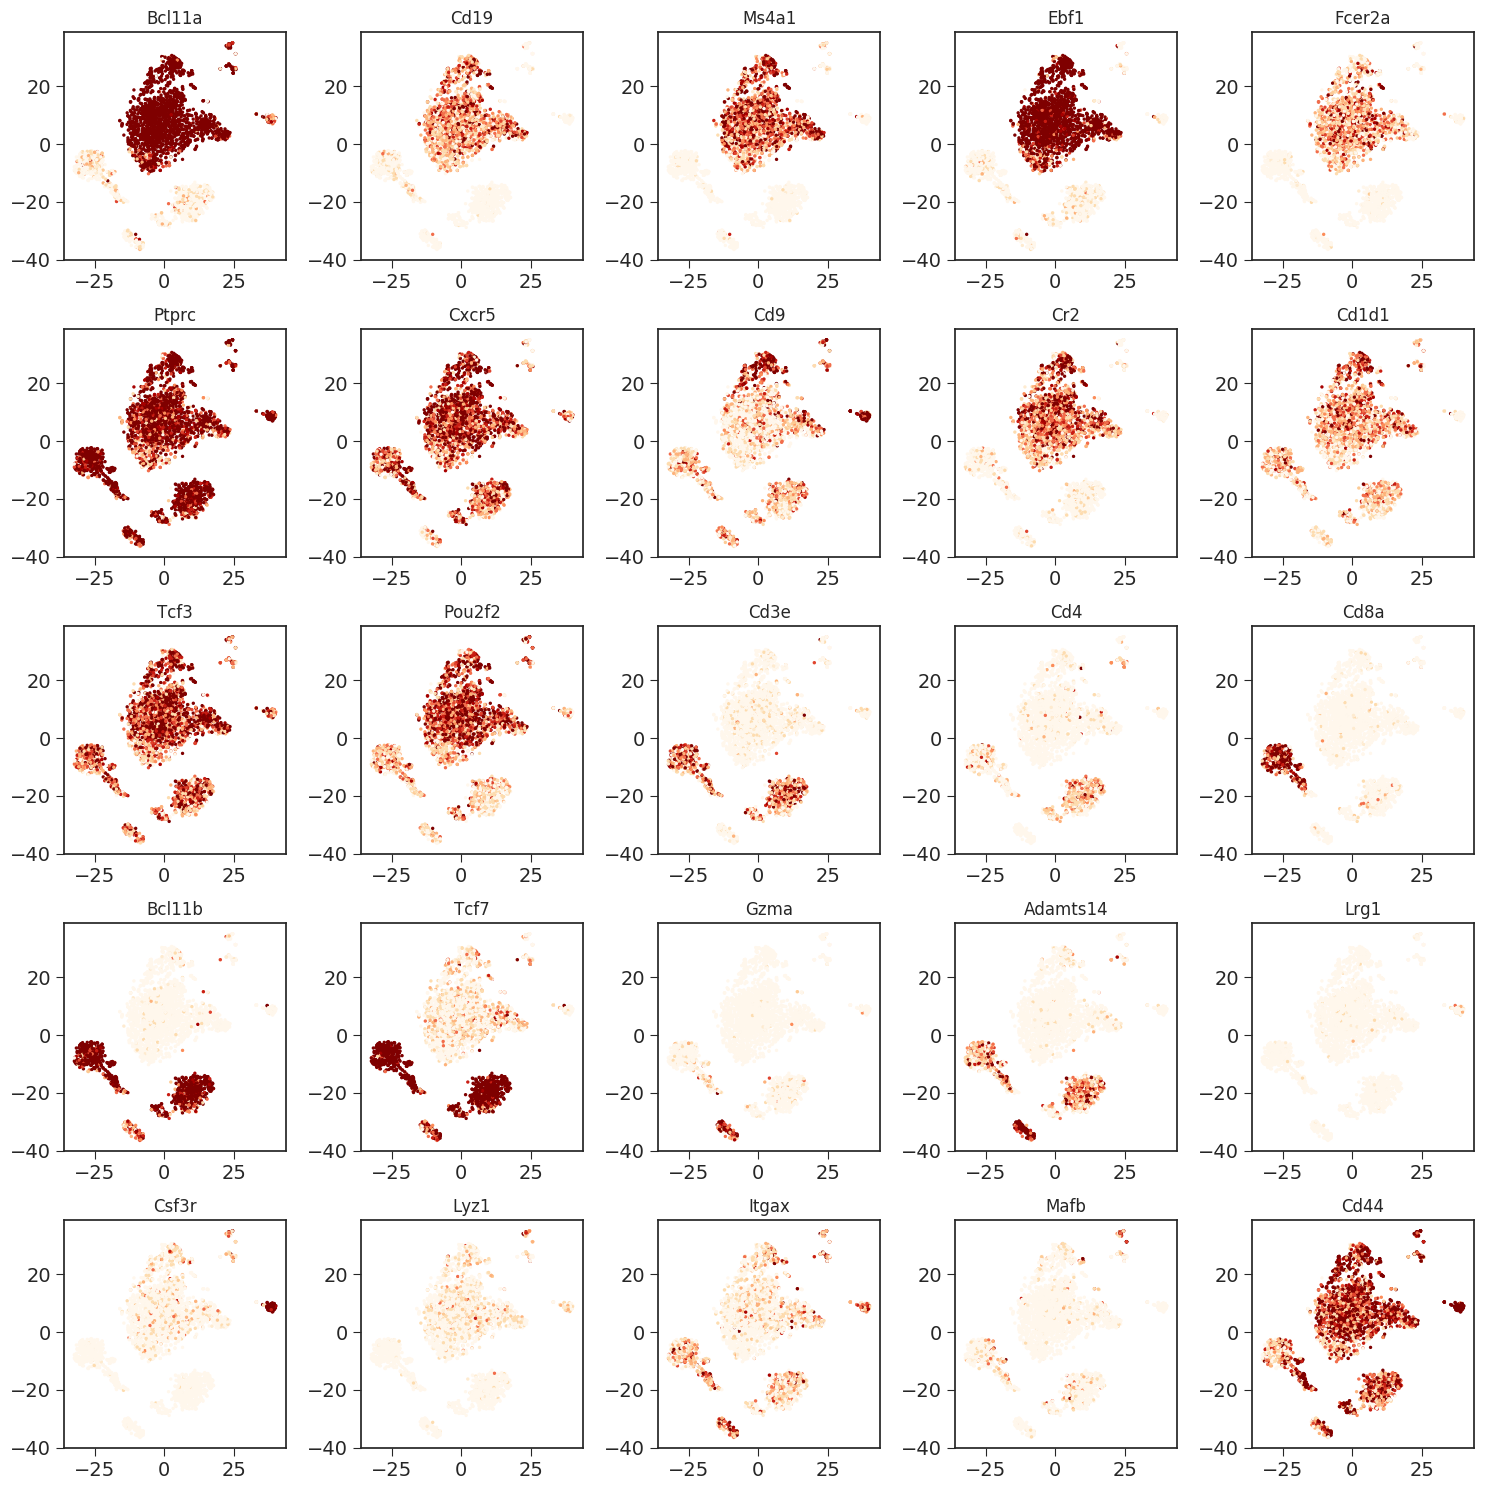

In [42]:
fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows=5)

ax = ax.flatten()

for i,j in enumerate(marker_genes):
    ax[i].scatter(sample_info["t-SNE Dimension 1"], sample_info["t-SNE Dimension 2"],
                  cmap="OrRd", c=gene_reg_sum.loc[j],
                  vmin=0, vmax=10, s=2)
    ax[i].set_title(j, fontsize=12)
fig.tight_layout()

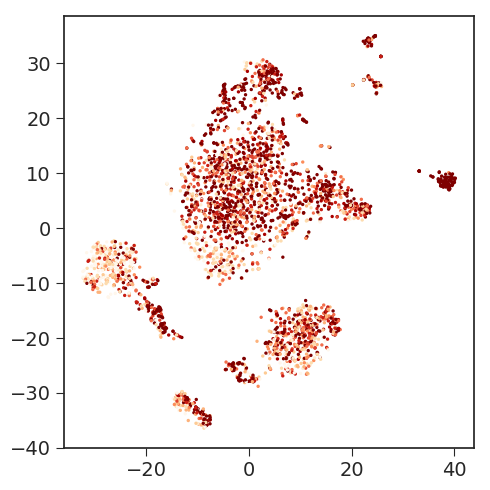

In [43]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(sample_info["t-SNE Dimension 1"], sample_info["t-SNE Dimension 2"],
           cmap="OrRd", c=gene_reg_sum.loc['Cd44'],
           vmin=0, vmax=10, s=2)
fig.tight_layout()

In [44]:
fig = plt.figure(figsize=(6,5))

for i in marker_genes:
    
    ax = fig.add_subplot(111)
    vmax = min(gene_reg_sum.loc[i].max(), 10)
    pax = ax.scatter(sample_info["t-SNE Dimension 1"], sample_info["t-SNE Dimension 2"],
                     cmap="OrRd", c=gene_reg_sum.loc[i],
                     vmin=0, vmax=10, s=2)
    ax.set_title(i)
    fig.colorbar(pax)
    fig.savefig('figures/marker_gene_{}.pdf'.format(i), bbox_inches='tight',
                transparent=True)
    fig.clf()

<Figure size 600x500 with 0 Axes>

# Annotate the clusters

In [45]:
cluster_annotation = { 0 : 'Granulocyte',
                       1 : 'Follicular_B',
                       2 : 'Memory_CD8_T',
                       3 : 'Naive_CD4_T',
                       4 : 'Marginal_Zone_B',
                       5 : 'Macrophage',
                       6 : 'Naive_CD8_T',
                       7 : 'Transitional_B',
                       8 : 'CD27-_Natural_Killer',
                       9 : 'Regulatory_T',
                      10 : 'Dendritic_cell',
                      11 : 'CD27+_Natural_Killer'}

sample_info['putative_cell_type'] = sample_info.cluster_labels.replace(cluster_annotation)
sample_info.putative_cell_type.value_counts()

Follicular_B            1358
Naive_CD4_T              454
Naive_CD8_T              331
Marginal_Zone_B          254
Transitional_B           223
Memory_CD8_T             116
Regulatory_T              89
Granulocyte               85
CD27-_Natural_Killer      75
CD27+_Natural_Killer      65
Dendritic_cell            61
Macrophage                55
Name: putative_cell_type, dtype: int64

In [46]:
sample_info.head(2)

frip  uniq_frags  mt_content  sequencing_depth  dup_level  \
mSp_rep7_276  0.716681     32270.0    0.015168            702521   0.947797   
mSp_rep7_267  0.714632     16449.0    0.028755            367383   0.948255   

              frac_open  mapping_rate plate          batch  t-SNE Dimension 1  \
mSp_rep7_276   0.172111         96.26  rep7  Sp#2 (n=2688)         -30.627532   
mSp_rep7_267   0.106115         96.20  rep7  Sp#2 (n=2688)          19.699694   

              t-SNE Dimension 2  cluster_labels putative_cell_type  
mSp_rep7_276          -9.802483               6        Naive_CD8_T  
mSp_rep7_267           1.610785               7     Transitional_B

In [47]:
# output sample_info

sample_info.to_csv('mSp_scATAC-seq/sample_info.csv')

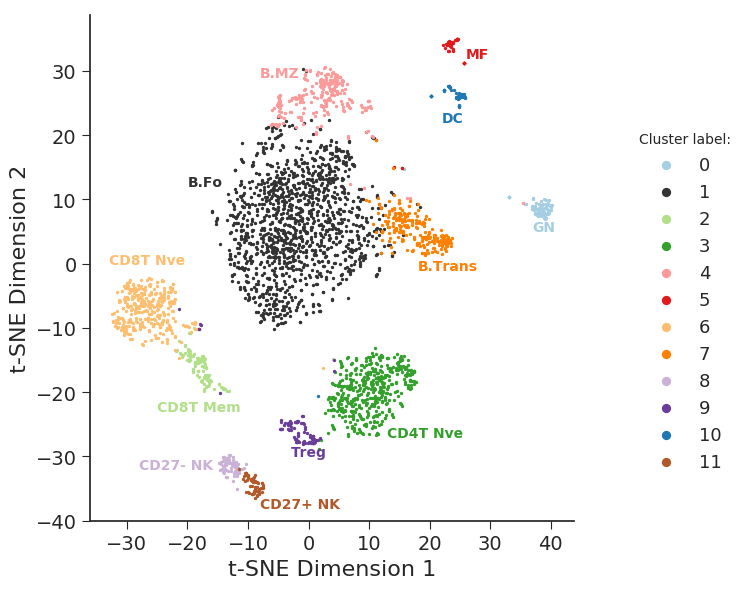

In [51]:
g = sns.FacetGrid(sample_info, hue='cluster_labels', size=6, palette=sns.color_palette(color12))
g.map(plt.scatter, 't-SNE Dimension 1', 't-SNE Dimension 2', s=2)
g.ax.legend(bbox_to_anchor=[1.1,0.8], title='Cluster label:')


# lgd = g.ax.get_legend()
# ltt = lgd.get_title()
# ltt.set_fontsize(15)
# # change legend labels from nubmers to cell types
# txt = lgd.get_texts()
# for t in txt:
#     cl = t.get_text()
#     t.set_text(cluster_annotation[int(cl)])

g.ax.text(-20, 12, 'B.Fo', fontsize=10, weight='bold', color=color12[1])

g.ax.text(-28, -32, 'CD27- NK', fontsize=10, weight='bold', color=color12[8])
g.ax.text(-8, -38, 'CD27+ NK', fontsize=10, weight='bold', color=color12[11])

g.ax.text(13, -27, 'CD4T Nve', fontsize=10, weight='bold', color=color12[3])
g.ax.text(-3, -30, 'Treg', fontsize=10, weight='bold', color=color12[9])

g.ax.text(-8, 29, 'B.MZ', fontsize=10, weight='bold', color=color12[4])
g.ax.text(37, 5, 'GN', fontsize=10, weight='bold', color=color12[0])

g.ax.text(-33, 0, 'CD8T Nve', fontsize=10, weight='bold', color=color12[6])
g.ax.text(-25, -23, 'CD8T Mem', fontsize=10, weight='bold', color=color12[2])

g.ax.text(22, 22, 'DC', fontsize=10, weight='bold', color=color12[10])
g.ax.text(26, 32, 'MF', fontsize=10, weight='bold', color=color12[5])
g.ax.text(18, -1, 'B.Trans', fontsize=10, weight='bold', color=color12[7])

plt.savefig('figures/tSNE_colored_by_clustering_annotation.pdf',
            bbox_inches='tight', transparent=True)

In [52]:
# output annotation of the top 500 cluster defining peaks

top_peaks['in_cell_type'] = top_peaks.class_.replace(cluster_annotation)
top_peaks.to_csv('mSp_scATAC-seq/logit_top_500_cluster_defining_peaks.tsv', sep='\t')

In [53]:
# output cell-type defining peaks coordinates for motifs analysis

top_peaks['peak_id'] = top_peaks.index.str.extract('(.*)', expand=False)

for c_label in logit.classes_:
    
    (
    top_peaks
    .query('class_ == @c_label')
    .loc[:,['Chr', 'Start', 'End', 'peak_id']]
    .to_csv('mSp_scATAC-seq/logit_cluster_{}_top_500_peaks.bed'.format(c_label),
            sep='\t', index=False, header=False)
    )

# Check genomic distribution of cell-type defining peaks

In [54]:
top_peaks.Annotation.str.split(' ').str[0].value_counts()

intron          2622
Intergenic      2382
promoter-TSS     571
exon             163
5'                91
TTS               90
3'                56
non-coding        19
Name: Annotation, dtype: int64

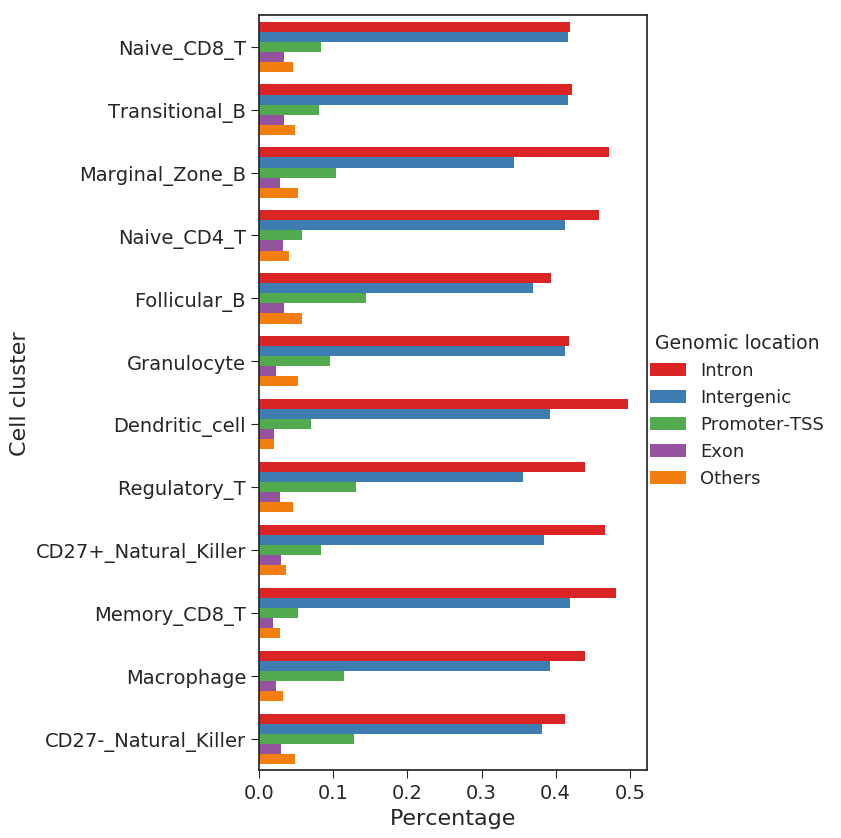

In [55]:
# treat homer Annotation of 5', TTS, 3' and non-coding as 'others'
labels = ['Intron', 'Intergenic', 'Promoter-TSS', 'Exon', 'Others']

dfs = []

for cell_type in sample_info.putative_cell_type.unique():
    sub_df = top_peaks.query('in_cell_type == @cell_type')
    distr = sub_df.Annotation.str.split(' ').str[0].value_counts()
    total = distr.values.sum()
    df = pd.DataFrame({'Percentage' : list(distr.values[:4] / total) \
                                      + [distr.values[4:].sum() / total]})
    df['Genomic location'] = labels
    df['Cell cluster'] = cell_type
    dfs.append(df)

gen_distr = pd.concat(dfs)

fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(x='Percentage', y='Cell cluster', hue='Genomic location',
            data=gen_distr, palette='Set1', ax=ax, saturation=.9)
lgd = ax.get_legend()
lgd.set_bbox_to_anchor([1.5,0.6])

fig.savefig('figures/genomic_distribution_of_top_500_peaks.pdf',
            bbox_inches='tight', transparent=True)

# Generate a heatmap of the top 500 x 12 = 6,000 peaks on cells ordered by clusters

In [53]:
cell_sort = sample_info.sort_values(by='cluster_labels').index
peak_sort = top_peaks.sort_values(by=['class_', 'weight'], ascending=[True, False]).index

In [54]:
df_matrix = pd.DataFrame(data = matrix.T,
                         index = bin_sc_count.index,
                         columns = bin_sc_count.columns)
df_matrix = df_matrix.loc[peak_sort, cell_sort]

In [55]:
top_peaks.head(3)

class_    weight    Chr      Start        End  \
peak                                                               
spleen_uPk_102966       0  0.017903   chr6  125483405  125483926   
spleen_uPk_30938        0  0.016020  chr13   13529031   13529798   
spleen_uPk_4841         0  0.014704   chr1  128712570  128713353   

                                          Annotation  Distance to TSS  \
peak                                                                    
spleen_uPk_102966  intron (NM_007657, intron 1 of 7)          11090.0   
spleen_uPk_30938                          Intergenic         -60995.0   
spleen_uPk_4841                           Intergenic        -120662.0   

                  Gene Name in_cell_type            peak_id  
peak                                                         
spleen_uPk_102966       Cd9  Granulocyte  spleen_uPk_102966  
spleen_uPk_30938       Lyst  Granulocyte   spleen_uPk_30938  
spleen_uPk_4841       Cxcr4  Granulocyte    spleen_uPk_4841

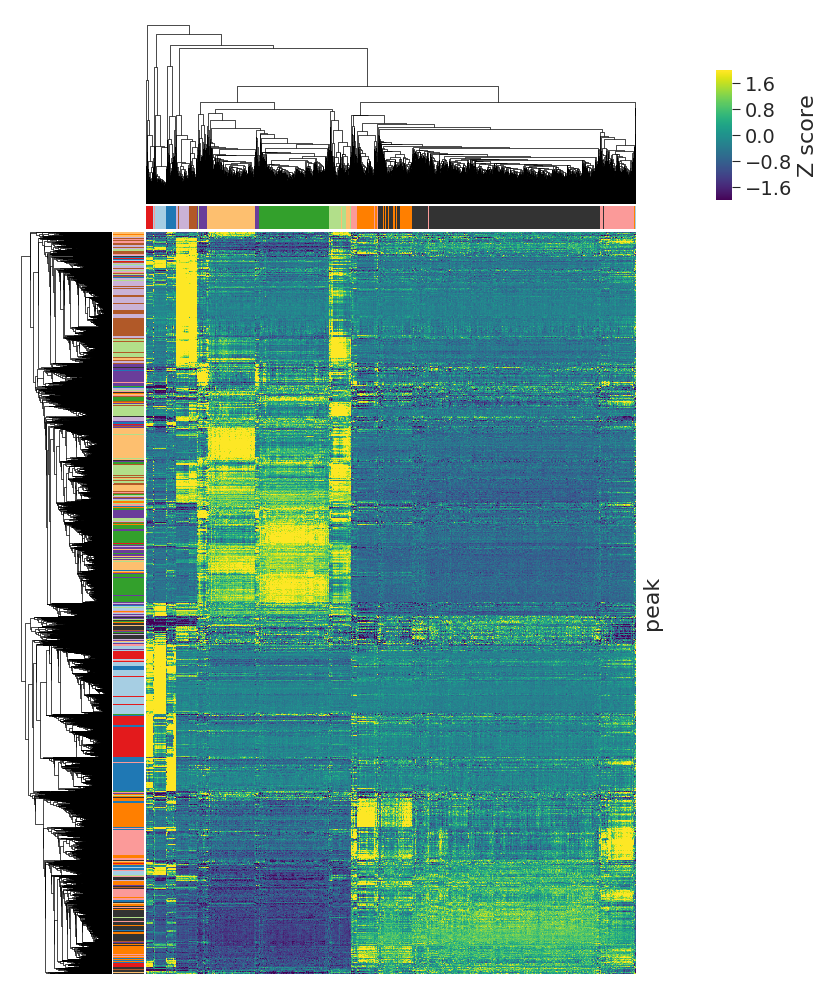

In [56]:
map_colors = {}
for i,j in enumerate(color12):
    map_colors[i] = j

sample_info['col_colors'] = sample_info.cluster_labels.replace(map_colors)
top_peaks['row_colors'] = top_peaks.class_.replace(map_colors)

clmp = sns.clustermap(df_matrix,
                      xticklabels=False, yticklabels=False,
                      z_score=0, vmin=-2, vmax=2, cmap='viridis',
                      col_colors=sample_info.loc[cell_sort, 'col_colors'].values,
                      row_colors=top_peaks.loc[peak_sort, 'row_colors'].values,
                      cbar_kws={'label' : 'Z score'}, figsize=(8,13))

clmp.cax.set_position([1, 0.72, 0.02, .1])

# to make the col_color shorter
col_color_pos = clmp.ax_col_colors.get_position()
clmp.ax_col_colors.set_position([col_color_pos.x0,
                                 col_color_pos.y0,
                                 col_color_pos.width,
                                 col_color_pos.height * 0.5])

# move column dendrogram a bit lower
col_den_pos = clmp.ax_col_dendrogram.get_position()
clmp.ax_col_dendrogram.set_position([col_den_pos.x0,
                                     col_den_pos.y0 - col_color_pos.height * 0.5,
                                     col_den_pos.width,
                                     col_den_pos.height])

clmp.savefig('figures/top_peak_by_cell_matrix_heatmap.png',
             bbox_inches='tight', transparent=True, dpi=600)

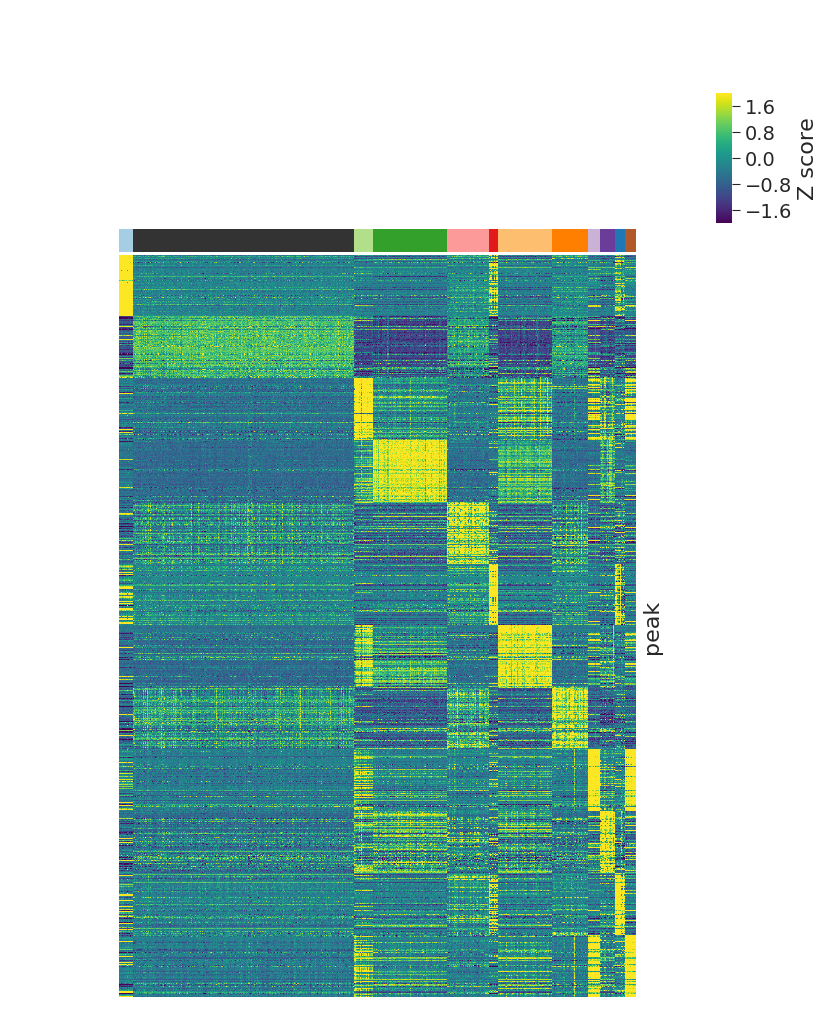

In [57]:
map_colors = {}
for i,j in enumerate(color12):
    map_colors[i] = j

sample_info['col_colors'] = sample_info.cluster_labels.replace(map_colors)

clmp = sns.clustermap(df_matrix,
                      xticklabels=False, yticklabels=False,
                      row_cluster=False, col_cluster=False,
                      z_score=0, vmin=-2, vmax=2, cmap='viridis',
                      col_colors=sample_info.loc[cell_sort, 'col_colors'].values,
                      cbar_kws={'label' : 'Z score'}, figsize=(8,13))

clmp.cax.set_position([1, 0.72, 0.02, .1])

# to make the col_color shorter
col_color_pos = clmp.ax_col_colors.get_position()
clmp.ax_col_colors.set_position([col_color_pos.x0,
                                 col_color_pos.y0,
                                 col_color_pos.width,
                                 col_color_pos.height * 0.5])

clmp.savefig('figures/top_peak_by_cell_matrix_heatmap_no_hcl.png',
             bbox_inches='tight', transparent=True, dpi=600)

# Pairwise peak identification

In [171]:
cd8_labels = [5, 8]

cd8_info = sample_info.query('cluster_labels in @cd8_labels')

In [173]:
logit = LogisticRegression(penalty='l2',
                           random_state=42,
                           solver='liblinear')
logit.fit(bin_sc_count.T.loc[cd8_info.index], cd8_info.cluster_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [200]:
# get cell-type (cluster) defining peaks

marker_peaks = pd.DataFrame({
               'class_': 8,
               'peak': X.columns[logit.coef_[0] < 0],
               'weight': abs(logit.coef_[0][logit.coef_[0]<0])
               })

marker_peaks.shape

(56665, 3)

In [201]:
# get top 500 peaks from each cell type prediction

top_peaks = (
            marker_peaks.sort_values('weight', ascending=False)
                        .groupby('class_')
                        .head(500)
                        .sort_values(['class_', 'weight'], ascending=[True, False])
            )

top_peaks.head(2)

class_               peak    weight
40430       8   spleen_uPk_90744  0.029384
46492       8  spleen_uPk_104178  0.026335

array([5, 8])

In [179]:
top_peaks.class_.value_counts()

5    500
Name: class_, dtype: int64

In [202]:
top_peaks.set_index('peak', inplace=True)
top_peaks = pd.concat([top_peaks,
                       homer.loc[top_peaks.index,
                                 ['Chr', 'Start', 'End',
                                  'Annotation', 'Distance to TSS',
                                  'Gene Name']
                                ]
                       ], axis=1)
top_peaks.sort_values(['class_', 'weight'], ascending=[True, False], inplace=True)

In [203]:
top_peaks.head(50)

class_    weight    Chr      Start        End  \
peak                                                               
spleen_uPk_90744        8  0.029384   chr5   36088993   36089842   
spleen_uPk_104178       8  0.026335   chr6  144670243  144671212   
spleen_uPk_43653        8  0.026238  chr15   59080938   59082600   
spleen_uPk_120707       8  0.025205   chr9   58112282   58112803   
spleen_uPk_51118        8  0.023212  chr16   91545500   91547823   
spleen_uPk_97645        8  0.022771   chr6   28350929   28351576   
spleen_uPk_45737        8  0.022622  chr15   85232920   85233915   
spleen_uPk_123754       8  0.022240   chr9  110879945  110880508   
spleen_uPk_100706       8  0.021976   chr6   87725272   87726142   
spleen_uPk_25647        8  0.021613  chr12   25958381   25959180   
spleen_uPk_29481        8  0.021171  chr12  107184189  107184986   
spleen_uPk_74574        8  0.020200   chr2  170050385  170051185   
spleen_uPk_34258        8  0.019838  chr13   73692256   73692906   
spleen_uPk_71436        8  0.019739   chr2  122764960  122765883   
spleen_uPk_103610       8  0.019724   chr6  134700454  134701280   
spleen_uPk_87609        8  0.019359   chr4  134641830  134642582   
spleen_uPk_20752        8  0.019241  chr11   76739088   76740009   
spleen_uPk_92006        8  0.019199   chr5   71903203   71904382   
spleen_uPk_107363       8  0.019014   chr7   67950779   67952473   
spleen_uPk_44555        8  0.019007  chr15   74768772   74769900   
spleen_uPk_30202        8  0.018820  chr12  115262459  115263011   
spleen_uPk_46712        8  0.018794  chr15  100181810  100182294   
spleen_uPk_71648        8  0.018597   chr2  127334060  127334466   
spleen_uPk_124563       8  0.018412   chr9  121454555  121455534   
spleen_uPk_107132       8  0.018387   chr7   64185086   64185989   
spleen_uPk_103050       8  0.018359   chr6  127245715  127246409   
spleen_uPk_108282       8  0.018229   chr7   83609713   83610576   
spleen_uPk_115918       8  0.018188   chr8   95369423   95370306   
spleen_uPk_40547        8  0.018091  chr14   79236186   79236989   
spleen_uPk_29480        8  0.017941  chr12  107183285  107183811   
spleen_uPk_4815         8  0.017811   chr1  128602425  128602953   
spleen_uPk_102310       8  0.017738   chr6  117890204  117891884   
spleen_uPk_29467        8  0.017596  chr12  107123541  107124805   
spleen_uPk_72363        8  0.017583   chr2  140066252  140067250   
spleen_uPk_104048       8  0.017500   chr6  142941789  142942519   
spleen_uPk_78763        8  0.017481   chr3   97273863   97274473   
spleen_uPk_80008        8  0.017367   chr3  121426035  121427497   
spleen_uPk_102130       8  0.017350   chr6  115559820  115560309   
spleen_uPk_66420        8  0.017237   chr2   25620332   25620865   
spleen_uPk_96071        8  0.017149   chr5  139930984  139931759   
spleen_uPk_93526        8  0.016920   chr5  107201076  107202362   
spleen_uPk_108245       8  0.016906   chr7   82957269   82958339   
spleen_uPk_38288        8  0.016889  chr14   47395033   47396584   
spleen_uPk_124767       8  0.016865   chr9  123767047  123767465   
spleen_uPk_37071        8  0.016806  chr14   18001740   18002680   
spleen_uPk_87432        8  0.016634   chr4  133506315  133507075   
spleen_uPk_53800        8  0.016541  chr17   31821113   31822071   
spleen_uPk_123206       8  0.016433   chr9  103489015  103490339   
spleen_uPk_62454        8  0.016419  chr19   14695290   14695900   
spleen_uPk_79613        8  0.016387   chr3  108401482  108402299   

                                               Annotation  Distance to TSS  \
peak                                                                         
spleen_uPk_90744       intron (NM_030889, intron 3 of 26)        -114604.0   
spleen_uPk_104178                              Intergenic          -2141.0   
spleen_uPk_43653         5' UTR (NM_144800, exon 1 of 15)            257.0   
spleen_uPk_120707   intron (NM_001166282, intron 3 of 19)           6281.0   
spleen_uPk_511

In [182]:
# have a look genes associated with the top 50 peaks in each cluster

top_genes = pd.DataFrame(
                         data = (top_peaks.groupby('class_')
                                          .head(50)['Gene Name']
                                          .T
                                ),
                         columns = ['cluster{}'.format(i) for i in cd8_labels])
top_genes

Empty DataFrame
Columns: [cluster5, cluster8]
Index: []

# Compare with ImmGen 2 (ignore this part)

In [151]:
immgen_bin_count = pd.DataFrame(index=bin_sc_count.index)
sf = iglob('combine_mSp_immgen/binarised_immgen/*.id')
for s in sf:
    fn = s.split('/')[-1]
    sn = fn.split('_')[0]
    immgen_bin_count[sn] = 0
    with open(s) as fh:
        pid = [i.strip() for i in fh if i.strip() in bin_sc_count.index]
    immgen_bin_count.loc[pid, sn] = 1
immgen_bin_count.shape

(116188, 63)

In [153]:
immgen_bin_count.head(2)

SRR5799398  SRR5799399  SRR5799400  SRR5799407  SRR5799408  \
pid                                                                        
spleen_uPk_1           1           1           1           1           1   
spleen_uPk_3           0           0           0           0           0   

              SRR5799410  SRR5799411  SRR5799412  SRR5799413  SRR5799414  \
pid                                                                        
spleen_uPk_1           1           1           1           1           1   
spleen_uPk_3           0           0           0           0           0   

                 ...      SRR5799551  SRR5799553  SRR5799554  SRR5799555  \
pid              ...                                                       
spleen_uPk_1     ...               1           1           1           1   
spleen_uPk_3     ...               1           0           0           0   

              SRR5799556  SRR5799557  SRR5799558  SRR5799559  SRR5799560  \
pid                                                                        
spleen_uPk_1           0           1           1           1           1   
spleen_uPk_3           0           0           0           0           0   

              SRR5799561  
pid                       
spleen_uPk_1           1  
spleen_uPk_3           0  

[2 rows x 63 columns]

In [157]:
# get only spleen data
immgen_anno = immgen_anno[immgen_anno["sample_title"].str.contains('.Sp#')]

In [158]:
immgen_anno['cell_type'] = immgen_anno.sample_title.str.split('.').str[0]
# merge cell subtypes into broad cell types
immgen_anno.replace({'cell_type' : {'T8' : 'T', 'Treg' : 'T', 'Tgd' : 'T'}}, inplace=True)
immgen_anno['cell_type'].value_counts()

B      25
T      20
NK      6
DC      6
MF      2
NKT     2
GN      2
Name: cell_type, dtype: int64

In [160]:
X = immgen_bin_count.T
y = immgen_anno.loc[immgen_bin_count.columns, 'cell_type']

In [161]:
# train a logistic regression modle

lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [162]:
lr.score(X, y)

1.0

In [163]:
# predict single cell data and check number of cells
Counter(lr.predict(bin_sc_count.T))

Counter({'B': 466, 'DC': 18, 'GN': 33, 'MF': 4, 'NK': 15, 'T': 317})

In [164]:
lr.classes_

array(['B', 'DC', 'GN', 'MF', 'NK', 'NKT', 'T'], dtype=object)

In [165]:
sample_info['proba'] = lr.predict_proba(bin_sc_count.T).max(1)

In [166]:
out = pd.DataFrame(data=lr.predict(bin_sc_count.T),
                   index=bin_sc_count.columns,
                   columns=['predicted_cell_type'])
out['predicted_proba'] = lr.predict_proba(bin_sc_count.T).max(1)

In [167]:
out.head(2)

predicted_cell_type  predicted_proba
mSp_rep1_001                   T         0.947617
mSp_rep1_002                   B         0.982295

In [168]:
sorted_idx = out.sort_values(by=['predicted_cell_type', 'predicted_proba']).index
y_prob = lr.predict_proba(bin_sc_count.T.loc[sorted_idx])

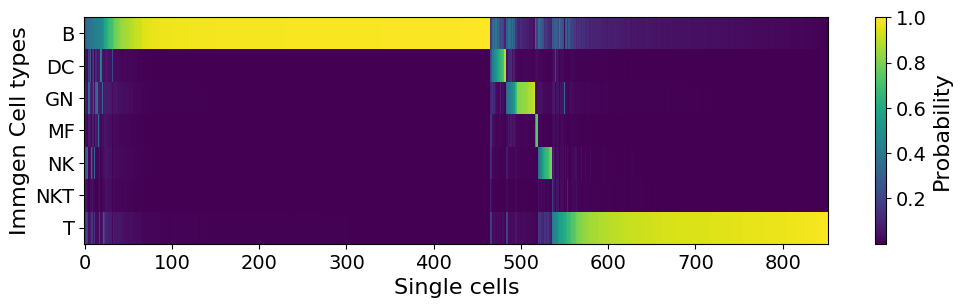

In [171]:
fig, ax = plt.subplots(figsize=(12,3))

plt.imshow(y_prob.T, cmap='viridis', vmax=1, aspect='auto')
plt.yticks(range(7), lr.classes_)
ax.set_xlabel('Single cells')
ax.set_ylabel('Immgen Cell types')
cb = plt.colorbar()
cb.ax.set_ylabel("Probability")
#plt.savefig('figures/logReg_prob.pdf', bbox_inches='tight', transparent=True)